# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Описание данных.

<b>Признаки:</b>
- DateCrawled: дата скачивания анкеты из базы;
- VehicleType: тип автомобильного кузова;
- RegistrationYear: год регистрации автомобиля;
- Gearbox: тип коробки передач;
- Power: мощность (л. с.);
- Model: модель автомобиля;
- Kilometer: пробег (км);
- RegistrationMonth: месяц регистрации автомобиля;
- FuelType: тип топлива;
- Brand: марка автомобиля;
- Repaired: была машина в ремонте или нет;
- DateCreated: дата создания анкеты;
- NumberOfPictures: количество фотографий автомобиля;
- PostalCode: почтовый индекс владельца анкеты (пользователя);
- LastSeen: дата последней активности пользователя.

<b>Целевой признак:</b>
- Price: цена (евро).

## Подготовка данных

### Импорт компонентов, библиотек и модулей

In [1]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_val_predict
from itertools import product

import warnings
warnings.filterwarnings('ignore')

### Загрузка датасета, изучение данных

In [2]:
try:
    data = pd.read_csv(r'C:\Users\a1\Desktop\autos.csv')
except:
    data=pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Удаление неинформативных данных

Удалим данные, которые не будут нужны в обучении модели: 
- DateCrawled; 
- NumberOfPictures; 
- PostalCode; 
- LastSeen; 
- DateCreated; 
- RegistrationMonth.

In [6]:
data = data.drop(columns=['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'RegistrationMonth'], axis=1)

Проверяем:

In [7]:
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


### Изменение типа и вида данных

Переведем названия столбцов в нижний регистр.

In [8]:
data.columns = data.columns.str.lower()

Проверяем:

In [9]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Изменим названия столбцов.

In [10]:
data = data.rename(columns={'vehicletype':'vehicle_type',
                            'registrationyear':'registration_year',
                            'fueltype': 'fuel_type',
                            'notrepaired':'not_repaired'}
                  )

Проверяем:

In [11]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проверим на пропуски:

In [12]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

### Пропуски, выборосы и аномалии.

Проведем работу с пропусками, а также проверим данные на выборсы и аномалии:

#### Цена автомобилей

Text(0.5, 1.0, 'График зависимости количества автомобилей от цены на них')

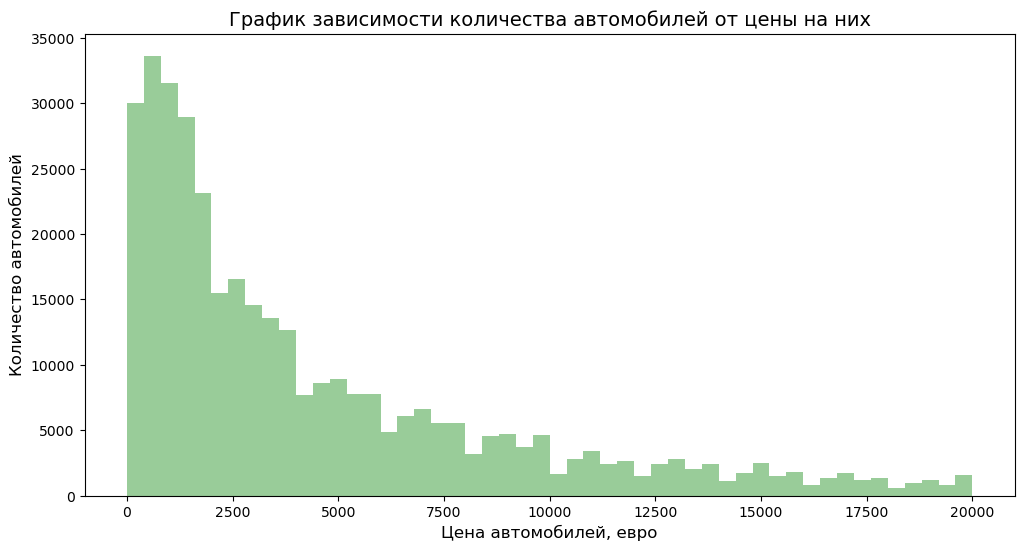

In [13]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(data['price'], kde=False, color='green', bins=50)
plt.ylabel('Количество автомобилей', fontsize = 12) 
plt.xlabel('Цена автомобилей, евро', fontsize = 12)
plt.title('График зависимости количества автомобилей от цены на них', fontsize = 14)

Верхняя граница:14425.00
Нижняя граница:0.00
Медиана:2700.00


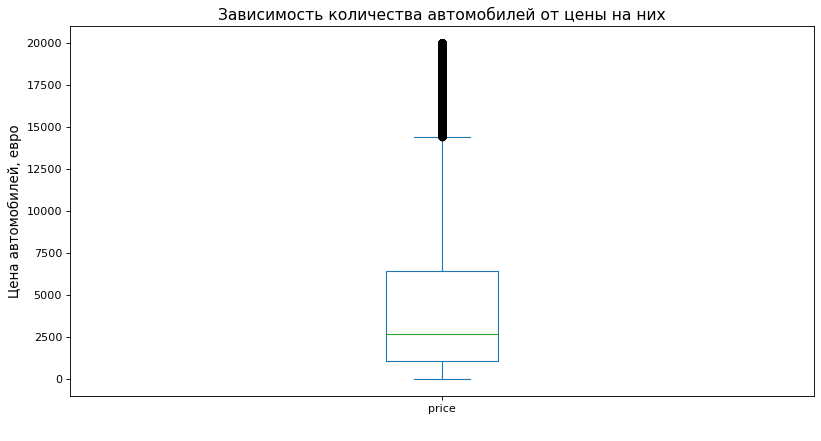

In [14]:
plt.figure(figsize=(12,6), dpi= 80)
list_of_items=['price']
for i in list_of_items:
    q1,q3=np.nanpercentile(data[i],[25, 75])
    iqr=q3-q1
    lower_bound=q1-(iqr*1.5)
    upper_bound=q3+(iqr*1.5)
    median_data=data[i].median()
    if lower_bound<0:
        lower_bound=0
    print('Верхняя граница:{:.2f}'. format(upper_bound))
    print('Нижняя граница:{:.2f}'. format(lower_bound))
    print('Медиана:{:.2f}'. format(median_data))    
    data[i].plot(kind='box') 
    plt.ylabel('Цена автомобилей, евро', fontsize = 12) 
    plt.xlabel(' ', fontsize = 14)
    plt.title('Зависимость количества автомобилей от цены на них', fontsize = 14)
    plt.show()

Удаляем данные с нулевой ценной:

In [15]:
data = data[data['price']!=0]

Text(0.5, 1.0, 'График зависимости количества автомобилей от цены на них')

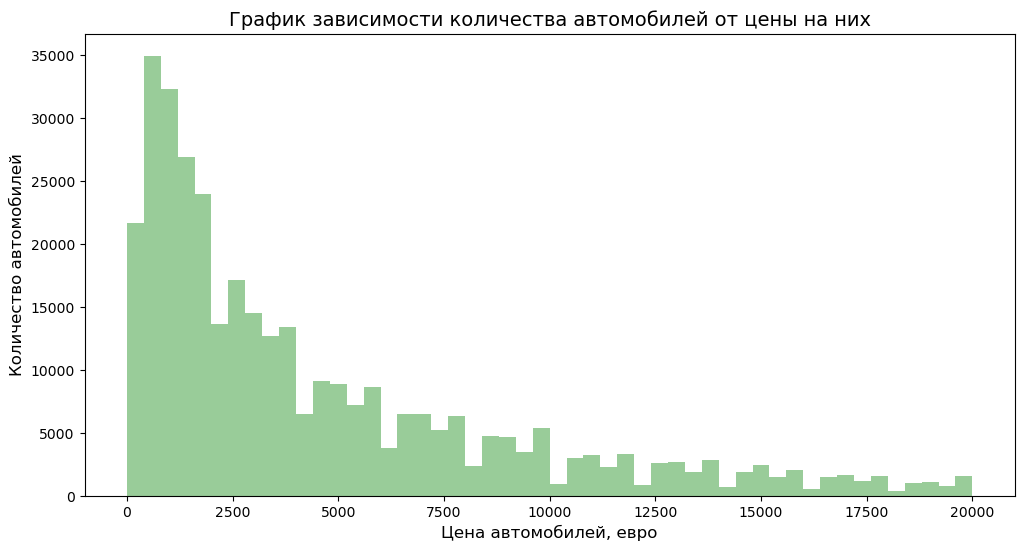

In [16]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(data['price'], kde=False, color='green', bins=50)
plt.ylabel('Количество автомобилей', fontsize = 12) 
plt.xlabel('Цена автомобилей, евро', fontsize = 12)
plt.title('График зависимости количества автомобилей от цены на них', fontsize = 14)

Верхняя граница:14450.00
Нижняя граница:0.00
Медиана:2890.00


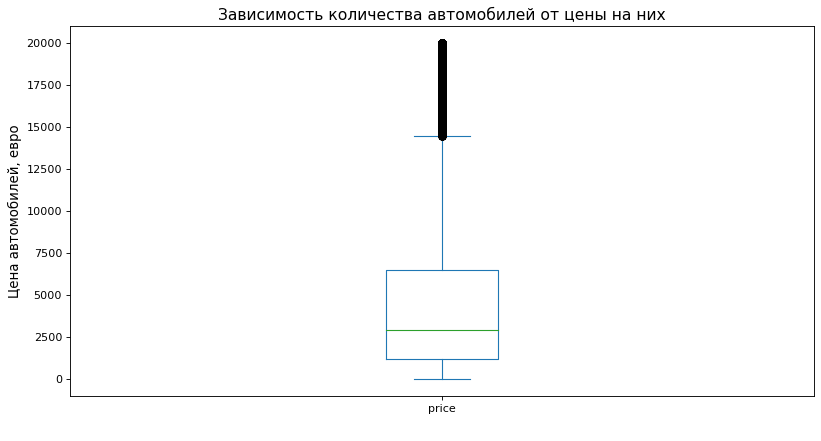

In [17]:
plt.figure(figsize=(12,6), dpi= 80)
list_of_items=['price']
for i in list_of_items:
    q1,q3=np.nanpercentile(data[i],[25, 75])
    iqr=q3-q1
    lower_bound=q1-(iqr*1.5)
    upper_bound=q3+(iqr*1.5)
    median_data=data[i].median()
    if lower_bound<0:
        lower_bound=0
    print('Верхняя граница:{:.2f}'. format(upper_bound))
    print('Нижняя граница:{:.2f}'. format(lower_bound))
    print('Медиана:{:.2f}'. format(median_data))    
    data[i].plot(kind='box') 
    plt.ylabel('Цена автомобилей, евро', fontsize = 12) 
    plt.xlabel(' ', fontsize = 14)
    plt.title('Зависимость количества автомобилей от цены на них', fontsize = 14)
    plt.show()

#### Тип автомобильного кузова

In [18]:
data['vehicle_type'].value_counts()

sedan          89405
small          78018
wagon          63701
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: vehicle_type, dtype: int64

In [19]:
data['vehicle_type'].isna().sum()

33750

В связи с тем, что физически нет возможности проверить тип автомобильного кузова, заменим пропуски на "other".

In [20]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

Проверим:

In [21]:
data['vehicle_type'].isna().sum()

0

In [22]:
data['vehicle_type'].value_counts()

sedan          89405
small          78018
wagon          63701
other          36836
bus            28345
convertible    19865
coupe          15636
suv            11791
Name: vehicle_type, dtype: int64

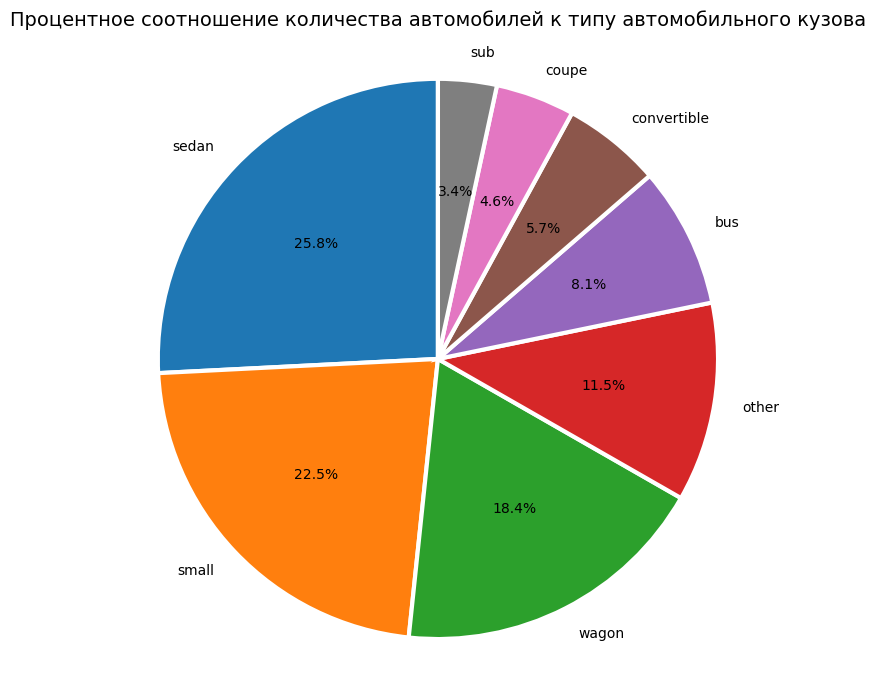

In [23]:
labels = 'sedan', 'small', 'wagon', 'other', 'bus', 'convertible', 'coupe', 'sub'
sizes = [91457, 79831, 65166, 40778, 28775, 20203, 16163, 11996]
explode = (0, 0, 0, 0, 0, 0, 0, 0)  

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        shadow=False, startangle=90)
ax1.axis('equal') 
plt.title('Процентное соотношение количества автомобилей к типу автомобильного кузова', pad = 20, fontsize = 14)
plt.show()

#### Год регистрации автомобиля

Проверим даты регистрации.

In [24]:
data['registration_year'].min()

1000

In [25]:
data['registration_year'].max()

9999

In [26]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 6500, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934,
       1938, 1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931,
       4500, 1602, 7800, 1947, 1927, 7100, 8200, 1946], dtype=int64)

Верхняя граница:2021.50
Нижняя граница:1985.50
Медиана:2003.00


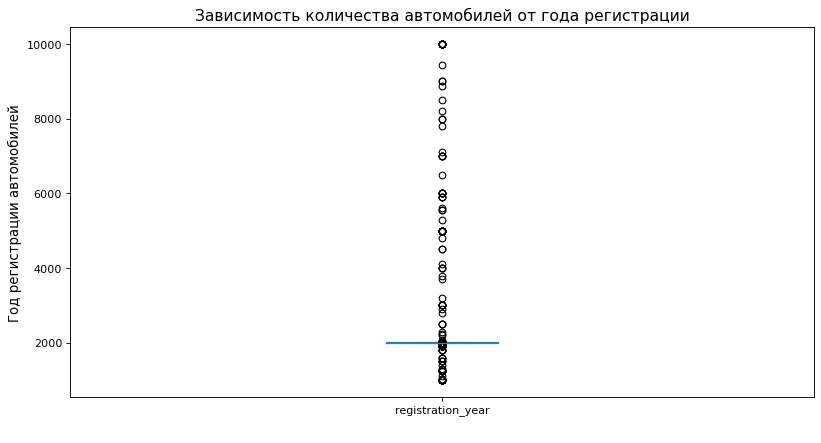

In [27]:
plt.figure(figsize=(12,6), dpi= 80)
list_of_items=['registration_year']
for i in list_of_items:
    q1,q3=np.nanpercentile(data[i],[25, 75])
    iqr=q3-q1
    lower_bound=q1-(iqr*1.5)
    upper_bound=q3+(iqr*1.5)
    median_data=data[i].median()
    if lower_bound<0:
        lower_bound=0
    print('Верхняя граница:{:.2f}'. format(upper_bound))
    print('Нижняя граница:{:.2f}'. format(lower_bound))
    print('Медиана:{:.2f}'. format(median_data))    
    data[i].plot(kind='box')
    plt.ylabel('Год регистрации автомобилей', fontsize = 12) 
    plt.xlabel(' ', fontsize = 14)
    plt.title('Зависимость количества автомобилей от года регистрации', fontsize = 14)
    plt.show()

Отсечем выбросы. Так как дата последней выгрузки стоит за 2016, будем отсчитывать начало производства машин от 1950 года и до 2016 года. Раритетные автомобили, более ранних годов выпуска, которые на ходу, будут стоить значительно выше максимальной цены в 20000 евро. 

In [28]:
data = data.query('1950 <= registration_year <= 2016')

Text(0.5, 1.0, 'График зависимости количества автомобилей от года их регистрации')

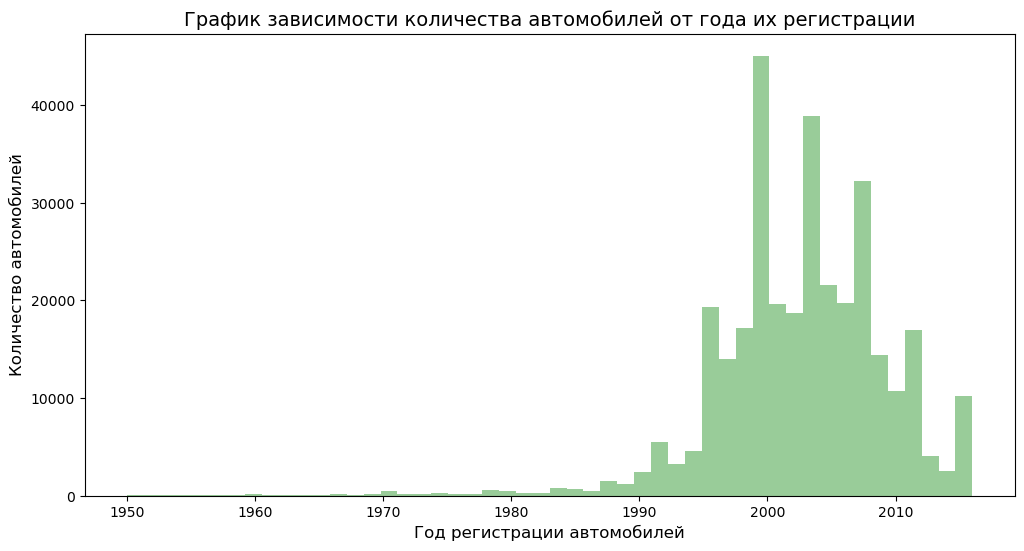

In [29]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(data['registration_year'], kde=False, color='green', bins=50)
plt.ylabel('Количество автомобилей', fontsize = 12) 
plt.xlabel('Год регистрации автомобилей', fontsize = 12)
plt.title('График зависимости количества автомобилей от года их регистрации', fontsize = 14)

Верхняя граница:2019.00
Нижняя граница:1987.00
Медиана:2003.00


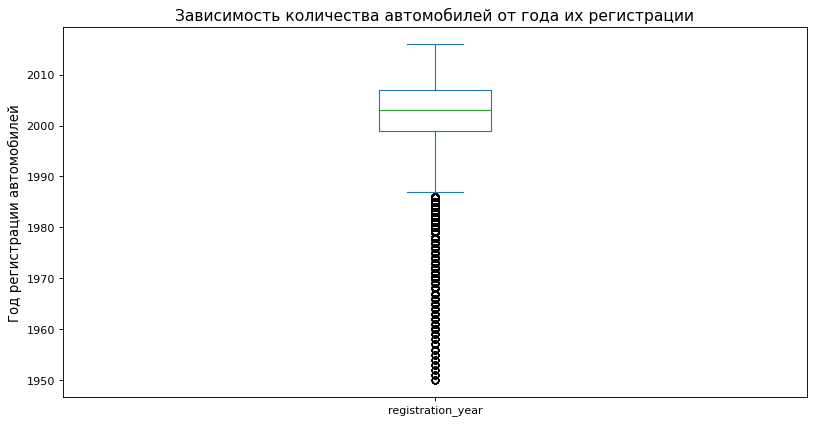

In [30]:
plt.figure(figsize=(12,6), dpi= 80)
list_of_items=['registration_year']
for i in list_of_items:
    q1,q3=np.nanpercentile(data[i],[25, 75])
    iqr=q3-q1
    lower_bound=q1-(iqr*1.5)
    upper_bound=q3+(iqr*1.5)
    median_data=data[i].median()
    if lower_bound<0:
        lower_bound=0
    print('Верхняя граница:{:.2f}'. format(upper_bound))
    print('Нижняя граница:{:.2f}'. format(lower_bound))
    print('Медиана:{:.2f}'. format(median_data))    
    data[i].plot(kind='box')
    plt.ylabel('Год регистрации автомобилей', fontsize = 12) 
    plt.xlabel(' ', fontsize = 14)
    plt.title('Зависимость количества автомобилей от года их регистрации', fontsize = 14)
    plt.show()

Проверим тип коробок передач автомобилей.

In [31]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [32]:
data['gearbox'].value_counts()

manual    251094
auto       63000
Name: gearbox, dtype: int64

In [33]:
data['gearbox'].isna().sum()

15545

Нет ясности что скрывается в пропусках. 

In [34]:
print('Удалив все объекты с пропусками, мы потеряем {:.1%} всех данных.'
      .format(1-len(data['gearbox'].dropna())/len(data['gearbox'])))

Удалив все объекты с пропусками, мы потеряем 4.7% всех данных.


Возможно, в пропусках скрываются, исходя из меньшего количества чем количество автомобилей с автоматическими коробками передач, другие их типы, например: вариаторные, роботизированные или преселективные. Будем исходить из этого предположения.

В связи с тем, что физически нет возможности проверить тип коробки передач автомобилей, заменим пропуски на "other".

In [35]:
data['gearbox'] = data['gearbox'].fillna('other')

In [36]:
data['gearbox'].isna().sum()

0

In [37]:
data['gearbox'].value_counts()

manual    251094
auto       63000
other      15545
Name: gearbox, dtype: int64

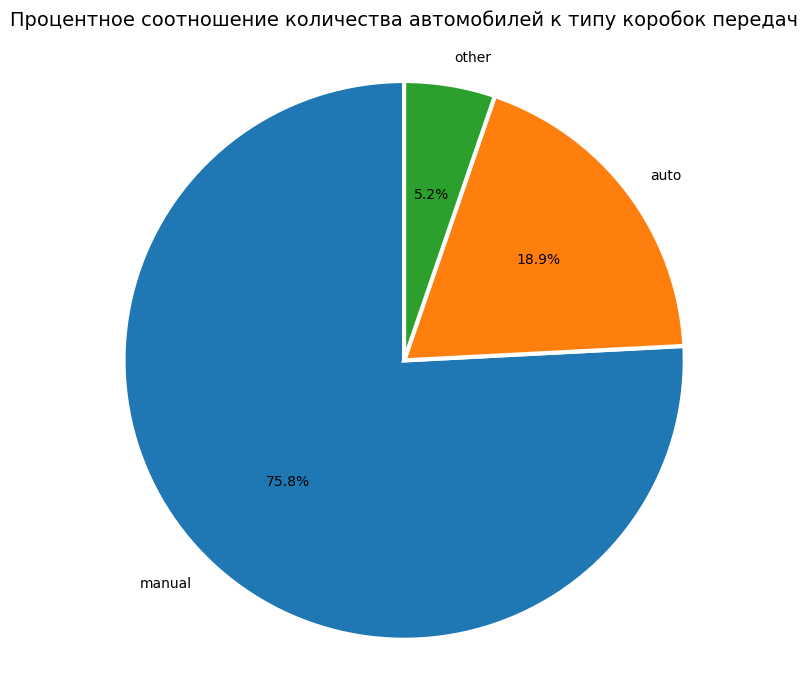

In [38]:
labels = 'manual', 'auto', 'other'
sizes = [257361, 64279, 17777]
explode = (0, 0, 0)  

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        shadow=False, startangle=90)
ax1.axis('equal') 
plt.title('Процентное соотношение количества автомобилей к типу коробок передач', pad = 20, fontsize = 14)
plt.show()

#### Мощность (л.с.)

In [39]:
data['power'].value_counts()

0        32787
75       22144
60       14771
150      13749
101      12415
         ...  
1506         1
5809         1
15020        1
5867         1
1241         1
Name: power, Length: 685, dtype: int64

In [40]:
data['power'].describe()

count    329639.000000
mean        111.932344
std         184.861470
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [41]:
data['fuel_type'].isna().sum()

24123

Text(0.5, 1.0, 'График зависимости количества автомобилей от мощности')

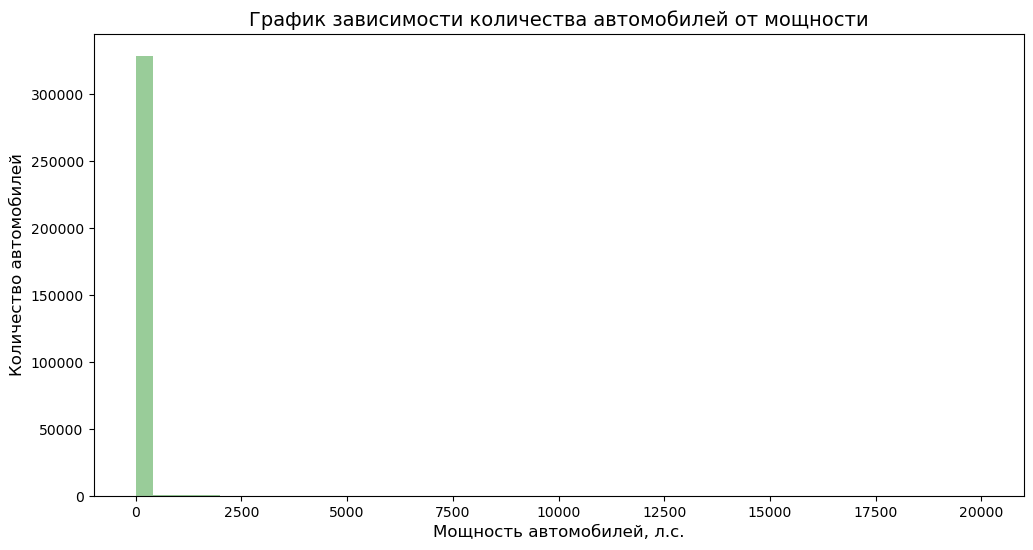

In [42]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(data['power'], kde=False, color='green', bins=50)
plt.ylabel('Количество автомобилей', fontsize = 12) 
plt.xlabel('Мощность автомобилей, л.с.', fontsize = 12)
plt.title('График зависимости количества автомобилей от мощности', fontsize = 14)

Верхняя граница:251.00
Нижняя граница:0.00
Медиана:105.00


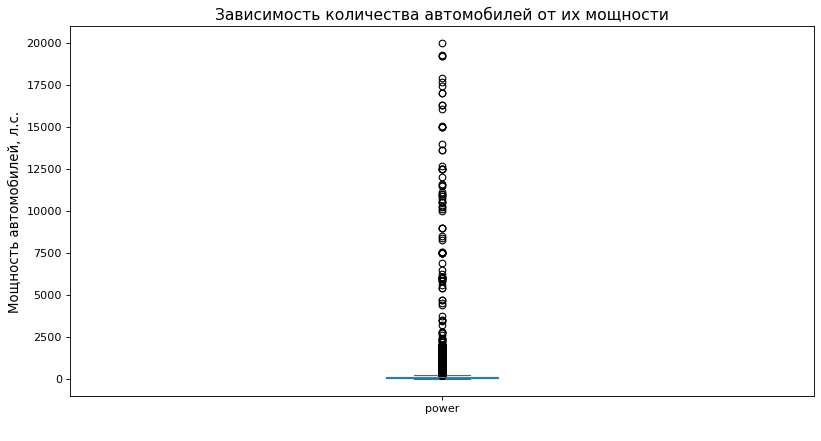

In [43]:
plt.figure(figsize=(12,6), dpi= 80)
list_of_items=['power']
for i in list_of_items:
    q1,q3=np.nanpercentile(data[i],[25, 75])
    iqr=q3-q1
    lower_bound=q1-(iqr*1.5)
    upper_bound=q3+(iqr*1.5)
    median_data=data[i].median()
    if lower_bound<0:
        lower_bound=0
    print('Верхняя граница:{:.2f}'. format(upper_bound))
    print('Нижняя граница:{:.2f}'. format(lower_bound))
    print('Медиана:{:.2f}'. format(median_data))    
    data[i].plot(kind='box')
    plt.ylabel('Мощность автомобилей, л.с.', fontsize = 12) 
    plt.xlabel(' ', fontsize = 14)
    plt.title('Зависимость количества автомобилей от их мощности', fontsize = 14)
    plt.show()

Убираем все данные с показателями мощности больше 500 л.с.:

In [44]:
data = data.query('power < 500')

Text(0.5, 1.0, 'График зависимости количества автомобилей от мощности')

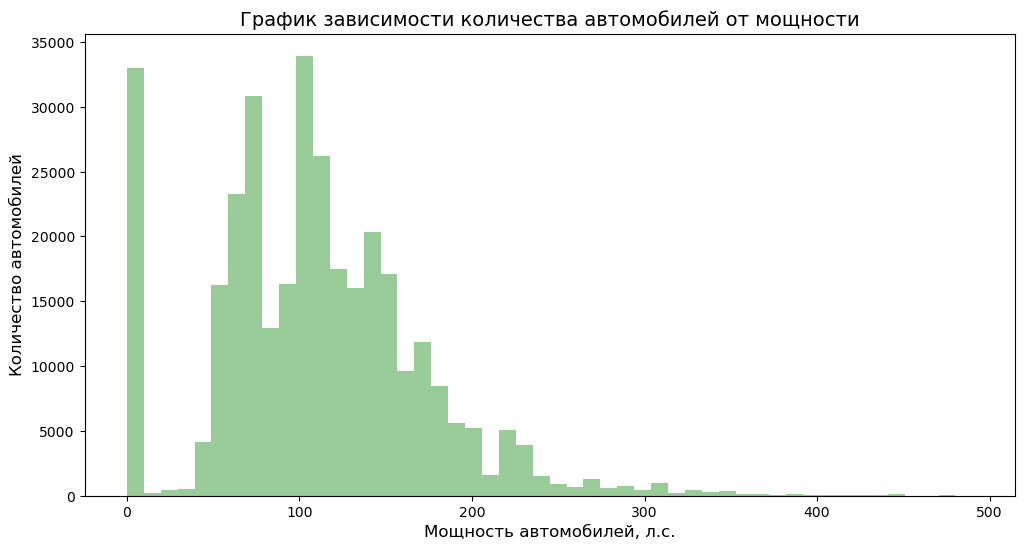

In [45]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(data['power'], kde=False, color='green', bins=50)
plt.ylabel('Количество автомобилей', fontsize = 12) 
plt.xlabel('Мощность автомобилей, л.с.', fontsize = 12)
plt.title('График зависимости количества автомобилей от мощности', fontsize = 14)

Несомненно, есть значительное количество маломощных автомобилей, например, популярный в Франции Une Voiture Sans Permis. Однако, в связи с тем, что найти название автомобилей, используя остальные значения кроме мощности невероятно сложно (36258 автомобилей) и, вероятностью, что часть автомобилей всё-таки будут иметь значения мощности выше 75, эти данные придётся ограничить как раз мощностью двигателя Une Voiture Sans Permis. Т.е. нижняя граница будет 5. 

In [46]:
data = data.query('5 <= power <= 500')

Text(0.5, 1.0, 'График зависимости количества автомобилей от мощности')

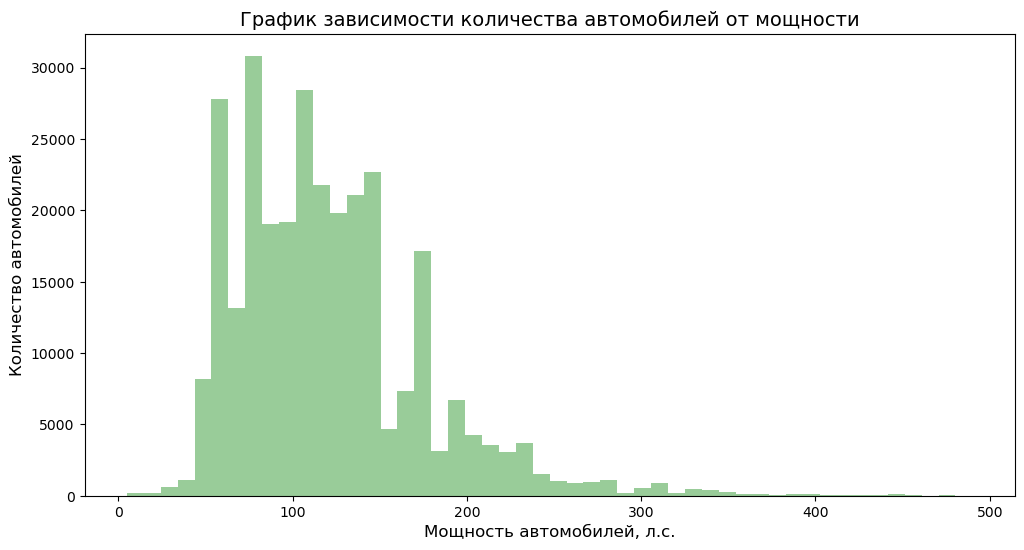

In [47]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(data['power'], kde=False, color='green', bins=50)
plt.ylabel('Количество автомобилей', fontsize = 12) 
plt.xlabel('Мощность автомобилей, л.с.', fontsize = 12)
plt.title('График зависимости количества автомобилей от мощности', fontsize = 14)

Верхняя граница:262.50
Нижняя граница:0.00
Медиана:111.00


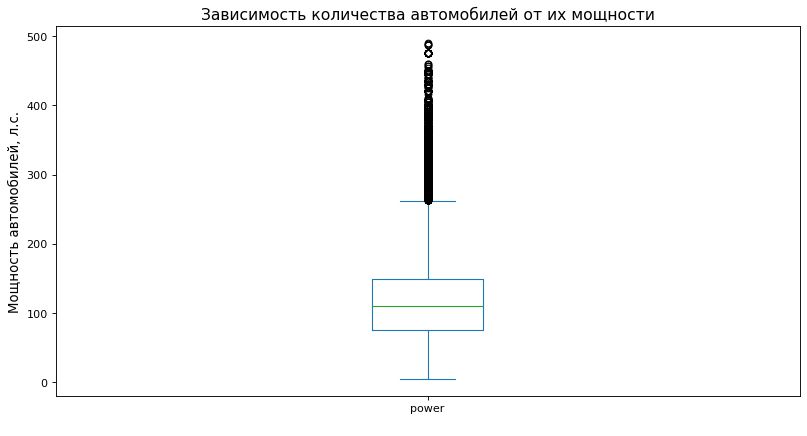

In [48]:
plt.figure(figsize=(12,6), dpi= 80)
list_of_items=['power']
for i in list_of_items:
    q1,q3=np.nanpercentile(data[i],[25, 75])
    iqr=q3-q1
    lower_bound=q1-(iqr*1.5)
    upper_bound=q3+(iqr*1.5)
    median_data=data[i].median()
    if lower_bound<0:
        lower_bound=0
    print('Верхняя граница:{:.2f}'. format(upper_bound))
    print('Нижняя граница:{:.2f}'. format(lower_bound))
    print('Медиана:{:.2f}'. format(median_data))    
    data[i].plot(kind='box')
    plt.ylabel('Мощность автомобилей, л.с.', fontsize = 12) 
    plt.xlabel(' ')
    plt.title('Зависимость количества автомобилей от их мощности', fontsize = 14)
    plt.show()

#### Модель автомобиля

In [49]:
data['model'].value_counts()

golf                  24717
other                 20409
3er                   17385
polo                  10691
corsa                 10128
                      ...  
serie_2                   5
kalina                    5
serie_3                   3
range_rover_evoque        2
rangerover                2
Name: model, Length: 249, dtype: int64

In [50]:
data['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'astra', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_m

In [51]:
data['model'].isna().sum()

11134

Заполним все пропуски на "other":

In [52]:
data['model'] = data['model'].fillna('other')

In [53]:
data['model'].isna().sum()

0

#### Пробег (км.)

In [54]:
data['kilometer'].value_counts()

150000    196541
125000     31812
100000     12843
90000      10311
80000       9035
70000       7814
60000       6845
50000       5659
40000       4515
30000       3912
20000       3280
5000        2863
10000        925
Name: kilometer, dtype: int64

Объеденяю данные по пробегу в 5000 км и 10000 км в одну подкатегорию '10000 km и менее' для лучшей визуализации.. 

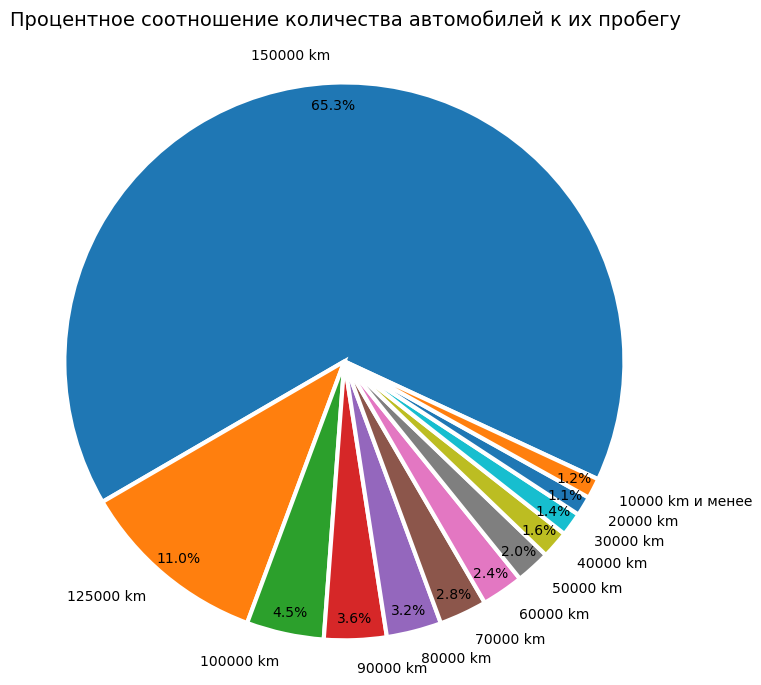

In [55]:
labels = ('150000 km', '125000 km', '100000 km', '90000 km', '80000 km', '70000 km',
          '60000 km', '50000 km' , '40000 km', '30000 km', '20000 km', '10000 km и менее'
         )

sizes = [182504, 30597, 12477, 10066, 8858, 7704, 6769, 5598, 4469, 3806, 3163, 3281] 
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, explode=explode, labels=labels, pctdistance = 0.92, autopct='%1.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        shadow=False, startangle=-25)
ax1.axis('equal') 
plt.title('Процентное соотношение количества автомобилей к их пробегу', pad = 20, fontsize = 14)
plt.show()

#### Тип топлива

In [56]:
data['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Petrol - это бензин. Gasoline - тоже бензин (только франкофоны используют слово gazole для обозначения дизельного топлива). lpg - liquefied petroleum gas, сжиженный природный газ. cng - compressed natural gas, компримированный природный газ. 

Объединим названия "petrol" и "gasoline" в "petrol":

In [57]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')

Проверим:

In [58]:
data['fuel_type'].value_counts()

petrol      275283
lpg           4685
cng            483
hybrid         202
other           87
electric        70
Name: fuel_type, dtype: int64

In [59]:
data['fuel_type'].isna().sum()

15545

Заменим пропуски на "other":

In [60]:
data['fuel_type'] = data['fuel_type'].fillna('other')

In [61]:
data['fuel_type'].value_counts()

petrol      275283
other        15632
lpg           4685
cng            483
hybrid         202
electric        70
Name: fuel_type, dtype: int64

Text(0.5, 1.0, 'Соотношение количества автомобилей к типу используемого топлива')

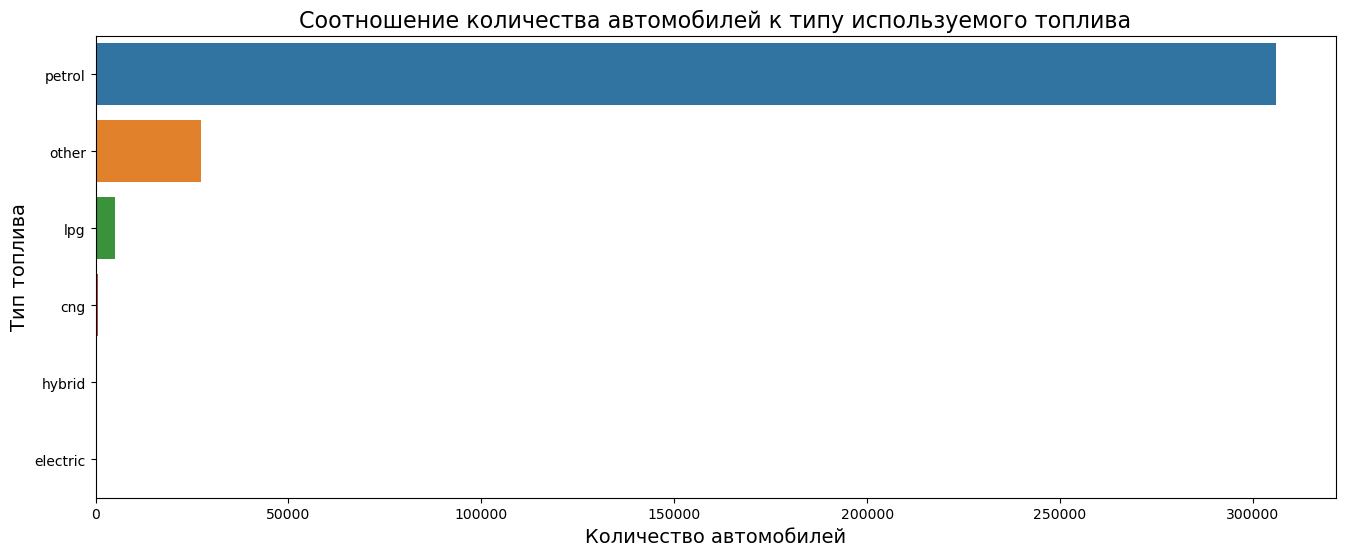

In [62]:
df = pd.DataFrame({'lab':['petrol', 'other', 'lpg', 'cng', 'hybrid', 'electric'], 'val':[306075, 27329, 5158, 542, 224, 89]})
plt.figure(figsize = (16, 6))
sns.barplot( 
    data = df,
    x = 'val',
    y = 'lab')
plt.xlabel('Количество автомобилей', fontsize = 14)
plt.ylabel('Тип топлива', fontsize = 14)
plt.title('Соотношение количества автомобилей к типу используемого топлива', fontsize = 16)

#### Марка автомобиля

In [63]:
data['brand'].value_counts()

volkswagen        64098
opel              32529
bmw               32264
mercedes_benz     27310
audi              25615
ford              20715
renault           13943
peugeot            9419
fiat               7680
seat               5859
skoda              4948
mazda              4726
smart              4484
citroen            4250
nissan             4046
toyota             4013
hyundai            3106
mini               2965
volvo              2825
mitsubishi         2498
honda              2364
kia                2088
alfa_romeo         1981
suzuki             1965
sonstige_autos     1797
chevrolet          1459
chrysler           1165
dacia               801
subaru              648
porsche             617
daihatsu            616
jeep                577
saab                474
land_rover          465
jaguar              437
daewoo              410
lancia              382
rover               367
trabant             292
lada                157
Name: brand, dtype: int64

#### Была машина в ремонте или нет

In [64]:
data['repaired'].value_counts()

no     224551
yes     28907
Name: repaired, dtype: int64

In [65]:
data['repaired'].isna().sum()

42897

Скорее всего, незаполненные данные означают, что машина не была в ремонте, так что заполним все пропуски значением: "no":

In [66]:
data['repaired'] = data['repaired'].fillna('no')

Проверяем:

In [67]:
data['repaired'].isna().sum()

0

In [68]:
data['repaired'].value_counts()

no     267448
yes     28907
Name: repaired, dtype: int64

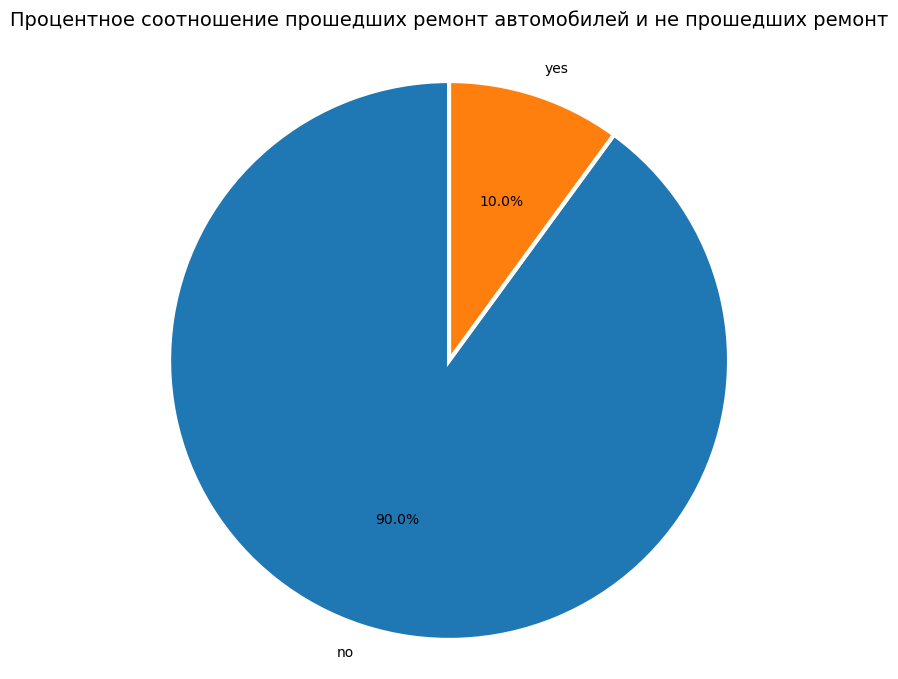

In [69]:
labels = 'no', 'yes'
sizes = [272536, 30373]
explode = (0, 0)  

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        shadow=False, startangle=90)
ax1.axis('equal') 
plt.title('Процентное соотношение прошедших ремонт автомобилей и не прошедших ремонт', pad = 20, fontsize = 14)
plt.show()

#### Выводы

- Загружен датасет, получена общая информация;
- Выполнено удаление не акутальных для обучения моделей данных, названия данных приведены к строчным значениям;
- Обнаружены пропуски, объяснена возможная причина их появления;
- Найдены аномальные объекты, откорректированны;
- Данные подготовленны для обучения моделей.

## Обучение моделей

В качестве моделей будем использовать:
- LinearRegression;
- RandomForestRegressor;
- CatBoostRegressor;
- LightGBMRegressor.

In [70]:
#encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
#data[['vehicle_type', 'registration_year', 'gearbox', 'power',
#       'model', 'kilometer', 'fuel_type', 'brand', 'repaired']] = encoder.fit_transform(
#    data[['vehicle_type', 'registration_year', 'gearbox', 'power',
#       'model', 'kilometer', 'fuel_type', 'brand', 'repaired']])

#### Определение признаков и разделение датасета на обучающую и тестовую выборки

Определим признаки и целевой признак для обучающей и тестовой выборок:

In [71]:
features = data.drop(['price'], axis=1)
target = data['price']

In [72]:
features

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,coupe,2011,manual,190,other,125000,petrol,audi,yes
2,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
354361,other,2016,auto,150,159,150000,other,alfa_romeo,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no


In [73]:
target

1         18300
2          9800
3          1500
4          3600
5           650
          ...  
354361     5250
354362     3200
354366     1199
354367     9200
354368     3400
Name: price, Length: 296355, dtype: int64

Произведём разделение данных на обучающую и тестовую выборки:

In [74]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

Проверим:

In [75]:
train_sample=features_train.shape[0]/features.shape[0]
test_sample=target_test.shape[0]/target.shape[0]

print('Размер тренировочной выборки - {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки - 75%
Размер тестовой выборки - 25%


In [76]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
250216,small,1995,manual,90,corsa,10000,petrol,opel,no
173160,small,2000,manual,60,corsa,150000,petrol,opel,no
309831,coupe,1999,manual,170,3er,150000,petrol,bmw,no
208170,small,1998,manual,90,civic,150000,petrol,honda,no
188139,sedan,2002,auto,102,a_klasse,150000,petrol,mercedes_benz,no


In [77]:
features_test.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
238730,convertible,2003,auto,200,a4,150000,petrol,audi,no
145805,sedan,1999,manual,101,focus,150000,petrol,ford,no
187365,small,2003,manual,58,twingo,90000,petrol,renault,no
79266,bus,2001,manual,75,agila,150000,petrol,opel,no
55156,other,2016,manual,103,145,150000,petrol,alfa_romeo,yes


Определим соотвтетствие признаков features_train и features_test: 

In [78]:
models_train = set(features_train['model'].unique())
models_test = set(features_test['model'].unique())
num_models_train = len(models_train)
num_models_test = len(models_test)
print(f'''Количество уникальных значений признка "model" в обеих выборках одинаковое: {num_models_train == num_models_test}
''')
print(f'''Уникальные значения признка "model" в обеих выборках одинаковые: {models_train == models_test}
''')
print(f'''Только в тренировочной выборке есть значения: {models_train - models_test}
''')
print(f'''Только в тестовой выборке есть значения: {models_test - models_train}
''')

Количество уникальных значений признка "model" в обеих выборках одинаковое: False

Уникальные значения признка "model" в обеих выборках одинаковые: False

Только в тренировочной выборке есть значения: {'rangerover', 'i3', 'range_rover_evoque'}

Только в тестовой выборке есть значения: set()



Чтобы избежать ошибки в кодировании через dummy из-за несовподения признаков, будем использовать OneHotEncoder для кодирования категориальных признаков для линейной регрессии и OrdinalEncoder для моделей градиентного бустинга и RandomForestRegression.

#### Подготовка признаков для модели LinearRegression

Выполним прямое кодирование категориальных признаков для модели LinearRegression:

In [79]:
features_lr = features.copy()

In [80]:
features_train_lr = features_train.copy()
features_test_lr = features_test.copy()
target_train_lr = target_train.copy()
target_test_lr = target_test.copy()

In [81]:
category_features_lr = ['vehicle_type','model','fuel_type','brand','gearbox','repaired']

In [82]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [83]:
encoder_ohe.fit(features_train_lr[category_features_lr])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

Добавляем закодированные признаки:

In [84]:
features_train_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_lr[category_features_lr])

In [85]:
features_test_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_lr[category_features_lr])

Удаляем незакодированные категориальные признаки:

In [86]:
features_train_lr = features_train_lr.drop(category_features_lr, axis=1)

In [87]:
features_test_lr = features_test_lr.drop(category_features_lr, axis=1)

Произведём масштабирование и преобразование числовых признаков:

In [88]:
numeric = ['power',
           'registration_year',
           'kilometer']

scaler = StandardScaler().fit(features_train[numeric])

features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

Проверяем все признаки в features_train_lr:

In [89]:
features_train_lr.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,gearbox_manual,gearbox_other,repaired_yes
250216,-1.204659,-0.570218,-3.220205,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
173160,-0.434919,-1.131753,0.589964,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
309831,-0.588867,0.927209,0.589964,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208170,-0.742815,-0.570218,0.589964,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
188139,-0.127023,-0.345604,0.589964,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
features_test_lr.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,gearbox_manual,gearbox_other,repaired_yes
238730,0.026925,1.488744,0.589964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145805,-0.588867,-0.364322,0.589964,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
187365,0.026925,-1.169189,-1.042965,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
79266,-0.280971,-0.850986,0.589964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55156,2.028250,-0.326886,0.589964,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Признаки для модели LinearRegression подготовлены.

#### Подготовка признаков для моделей градиентного бустинга и RandomForestRegression

Определим признаки для моделей градиентного бустинга и RandomForestRegression и разделеим выборки на обучающую и тестовую:

In [91]:
features_gbm = features.copy()

In [92]:
features_train_gbm = features_train.copy()
features_test_gbm = features_test.copy()
target_train_gbm = target_train.copy()
target_test_gbm = target_test.copy()

In [93]:
category_features_gbm = ['vehicle_type','model','fuel_type','brand','gearbox','repaired']

In [94]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [95]:
columns=['vehicle_type','model','fuel_type','brand','gearbox','repaired']
features_encoder = pd.DataFrame(encoder.fit_transform(features_gbm[columns]),
                            columns=features_gbm[columns].columns,
                           index=features_gbm[columns].index)
for column in columns:
    features_gbm[column] = features_encoder[column]
features_gbm

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,2.0,2011,1.0,190,166.0,125000,5.0,1.0,1.0
2,6.0,2004,0.0,163,117.0,125000,5.0,14.0,0.0
3,5.0,2001,1.0,75,116.0,150000,5.0,38.0,0.0
4,5.0,2008,1.0,69,101.0,90000,5.0,31.0,0.0
5,4.0,1995,1.0,102,11.0,150000,5.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
354361,3.0,2016,0.0,150,4.0,150000,4.0,0.0,0.0
354362,4.0,2004,1.0,225,140.0,150000,5.0,30.0,1.0
354366,1.0,2000,0.0,101,106.0,125000,5.0,32.0,0.0
354367,0.0,1996,1.0,102,223.0,150000,5.0,38.0,0.0


Добавляем закодированные признаки:

In [96]:
features_train_gbm[category_features_gbm] = encoder.transform(
    features_train_gbm[category_features_gbm])
features_test_gbm[category_features_gbm] = encoder.transform(
    features_test_gbm[category_features_gbm])

In [97]:
features_train_gbm.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
250216,5.0,1995,1.0,90,83.0,10000,5.0,24.0,0.0
173160,5.0,2000,1.0,60,83.0,150000,5.0,24.0,0.0
309831,2.0,1999,1.0,170,11.0,150000,5.0,2.0,0.0
208170,5.0,1998,1.0,90,73.0,150000,5.0,11.0,0.0
188139,4.0,2002,0.0,102,33.0,150000,5.0,20.0,0.0


In [98]:
features_test_gbm.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
238730,1.0,2003,0.0,200,29.0,150000,5.0,1.0,0.0
145805,4.0,1999,1.0,101,103.0,150000,5.0,10.0,0.0
187365,5.0,2003,1.0,58,226.0,90000,5.0,27.0,0.0
79266,0.0,2001,1.0,75,35.0,150000,5.0,24.0,0.0
55156,3.0,2016,1.0,103,1.0,150000,5.0,0.0,1.0


Произведём масштабирование и преобразование числовых признаков:

In [99]:
numeric_features_gbm = ['power', 'registration_year', 'kilometer']

In [100]:
scaler = StandardScaler()
scaler.fit(features_train_gbm[numeric_features_gbm])
features_train_gbm[numeric_features_gbm] = scaler.transform(
    features_train_gbm[numeric_features_gbm])
features_test_gbm[numeric_features_gbm] = scaler.transform(
    features_test_gbm[numeric_features_gbm])

In [101]:
features_train_gbm.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
250216,5.0,-1.204659,1.0,-0.570218,83.0,-3.220205,5.0,24.0,0.0
173160,5.0,-0.434919,1.0,-1.131753,83.0,0.589964,5.0,24.0,0.0
309831,2.0,-0.588867,1.0,0.927209,11.0,0.589964,5.0,2.0,0.0
208170,5.0,-0.742815,1.0,-0.570218,73.0,0.589964,5.0,11.0,0.0
188139,4.0,-0.127023,0.0,-0.345604,33.0,0.589964,5.0,20.0,0.0


In [102]:
features_test_gbm.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
238730,1.0,0.026925,0.0,1.488744,29.0,0.589964,5.0,1.0,0.0
145805,4.0,-0.588867,1.0,-0.364322,103.0,0.589964,5.0,10.0,0.0
187365,5.0,0.026925,1.0,-1.169189,226.0,-1.042965,5.0,27.0,0.0
79266,0.0,-0.280971,1.0,-0.850986,35.0,0.589964,5.0,24.0,0.0
55156,3.0,2.028250,1.0,-0.326886,1.0,0.589964,5.0,0.0,1.0


Признаки для моделей градиентного бустинга и RandomForestRegression подготовлены.

Проверим размерности признаков и целевого признака выборок для моделей градиентного бустинга и дерева решений:

In [103]:
print('features_train:', features_train_gbm.shape)
print('features_test:', features_test_gbm.shape)
print('target_train:', target_train_gbm.shape)
print('target_test:', target_test_gbm.shape)

features_train: (222266, 9)
features_test: (74089, 9)
target_train: (222266,)
target_test: (74089,)


Проверим размерности признаков и целевого признака выборок для модели линейной регрессии:

In [104]:
print('features_train:', features_train_lr.shape)
print('features_test:', features_test_lr.shape)
print('target_train:', target_train_lr.shape)
print('target_test:', target_test_lr.shape)

features_train: (222266, 305)
features_test: (74089, 305)
target_train: (222266,)
target_test: (74089,)


Для расчёта целевой метрики используем RMSE и напишем функцию:

In [105]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков.

In [106]:
def illustration_target(test, predict):
    rmse= mean_squared_error(test, predict)
    mae=mean_absolute_error(test, predict)
    plt.figure(figsize=(12, 6))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.text(16122,11225,'MAE={:.2f}'.format(mae))
    plt.text(16122,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(12, 6))
    plt.plot(predict, test, 'x', alpha=0.5)   
    plt.xlim(-5000,25000)
    plt.ylim(0,20000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

Для понимания, какие факторы важны при моделировании, создадим функцию, используя "feature_importances".

In [107]:
def importances(model, features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

#### LinearRegression

In [108]:
model_lr = LinearRegression()

Вектор оценок качества модели по результатам кросс-валидации:

In [109]:
%%time
start = time.time()
scores_lr = cross_val_score(model_lr, features_train_lr, target_train_lr, cv=5, scoring='neg_root_mean_squared_error')
end = time.time()
v_lr=round(end-start,2)
print(scores_lr)

[-2656.82024263 -2657.32719887 -2627.79975785 -2643.48169076
 -2622.85066199]
Wall time: 38.8 s


Средняя метрика RMSE:

In [110]:
print('Средняя оценка:', pd.Series(scores_lr).mean())

Средняя оценка: -2641.655910419183


In [111]:
rmse_lr = abs(pd.Series(scores_lr).mean())

In [112]:
rmse_lr

2641.655910419183

Обучим модель на тренировочных данных:

In [113]:
%%time
start = time.time()
model_lr.fit(features_train_lr, target_train_lr)
end = time.time()
f_lr=round(end-start,2)

Wall time: 9.13 s


Произведём расчёт времени предсказания:

In [114]:
%%time
start = time.time()
predict_lr = model_lr.predict(features_train_lr)
end = time.time()
p_lr=round(end-start,2)

Wall time: 342 ms


Показатели предсказания модели LinearRegression.

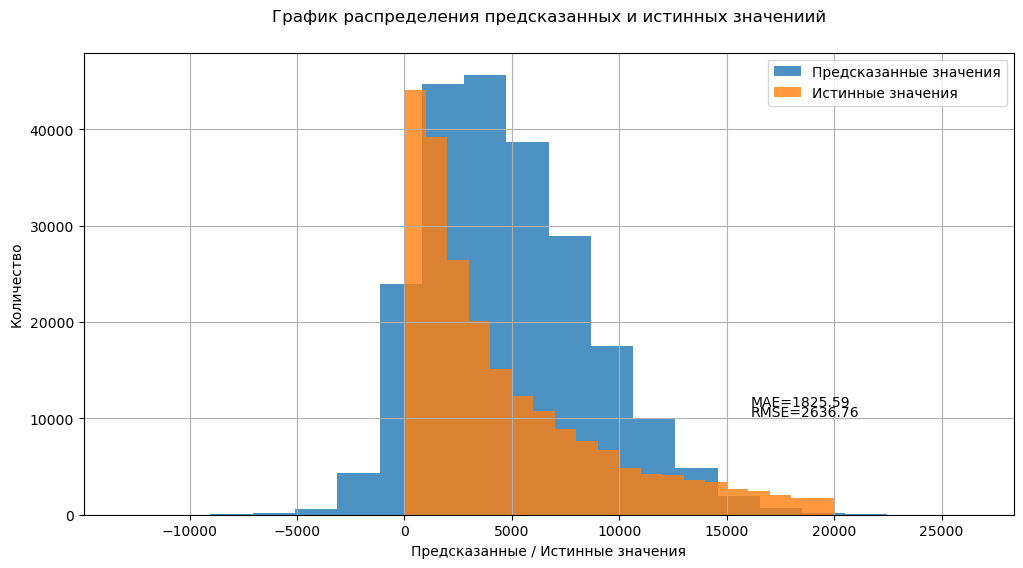

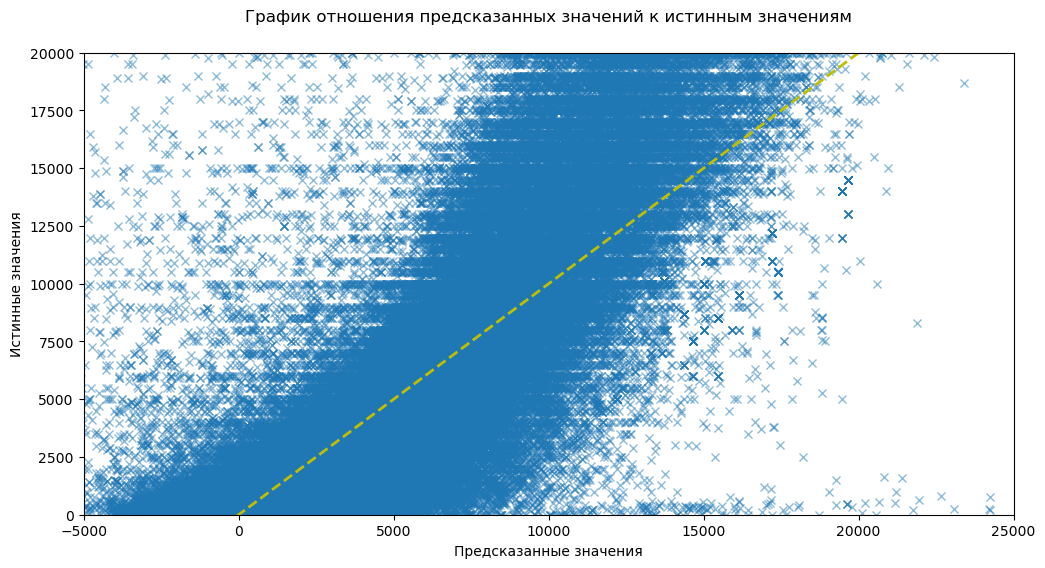

In [115]:
illustration_target(target_train_lr, predict_lr)

Факторы важности модели LinearRegression отсутствуют по причине простоты модели. 

В качестве модели обучения линейная регрессия не подходит, так как значение метрики RMSE более 2500. 

#### RandomForestRegressor

In [116]:
model_rf = RandomForestRegressor(random_state=12345, criterion='mse', warm_start=False, n_estimators=100)

In [117]:
%%time
start = time.time()
scores_rf = cross_val_score(model_rf, features_train_gbm, target_train_gbm, cv=5, scoring='neg_root_mean_squared_error')
end = time.time()
v_rf=round(end-start,2)
print(scores_rf)

[-1620.11278241 -1611.02366805 -1614.79876411 -1620.36297562
 -1596.80060941]
Wall time: 5min 51s


Средняя метрика RMSE:

In [118]:
print('Средняя оценка:', pd.Series(scores_rf).mean())

Средняя оценка: -1612.6197599206464


In [119]:
rmse_rf = abs(pd.Series(scores_rf).mean())

In [120]:
rmse_rf

1612.6197599206464

Обучим модель на тренировочных данных:

In [121]:
%%time
start = time.time()
model_rf.fit(features_train_gbm, target_train_gbm)
end = time.time()
f_rf=round(end-start,2)

Wall time: 1min 28s


Произведём расчёт времени предсказания:

In [122]:
%%time
start = time.time()
predict_rf = model_rf.predict(features_train_gbm)
end = time.time()
p_rf=round(end-start,2)

Wall time: 18.5 s


Показатели предсказания модели RandomForestRegressor:

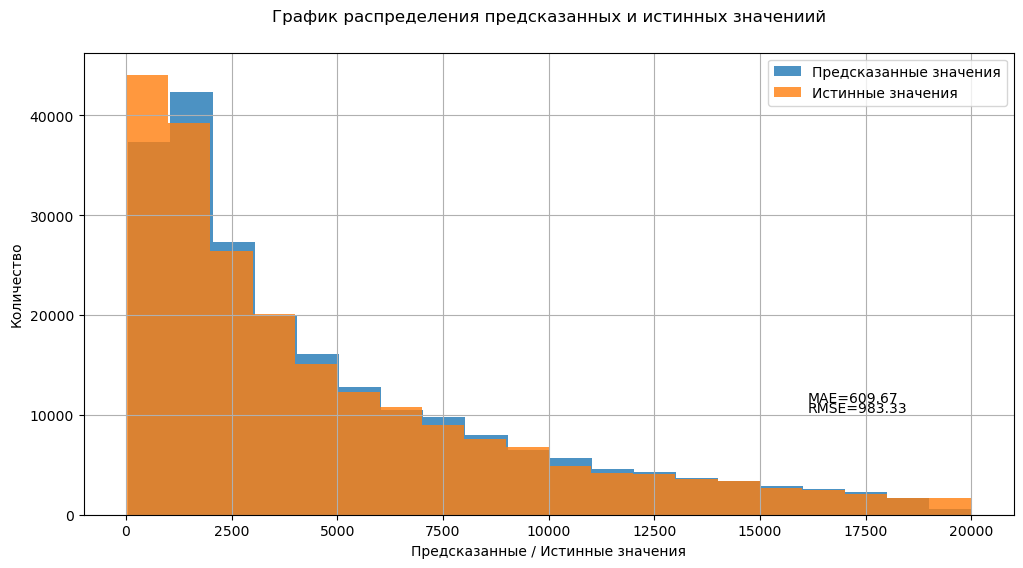

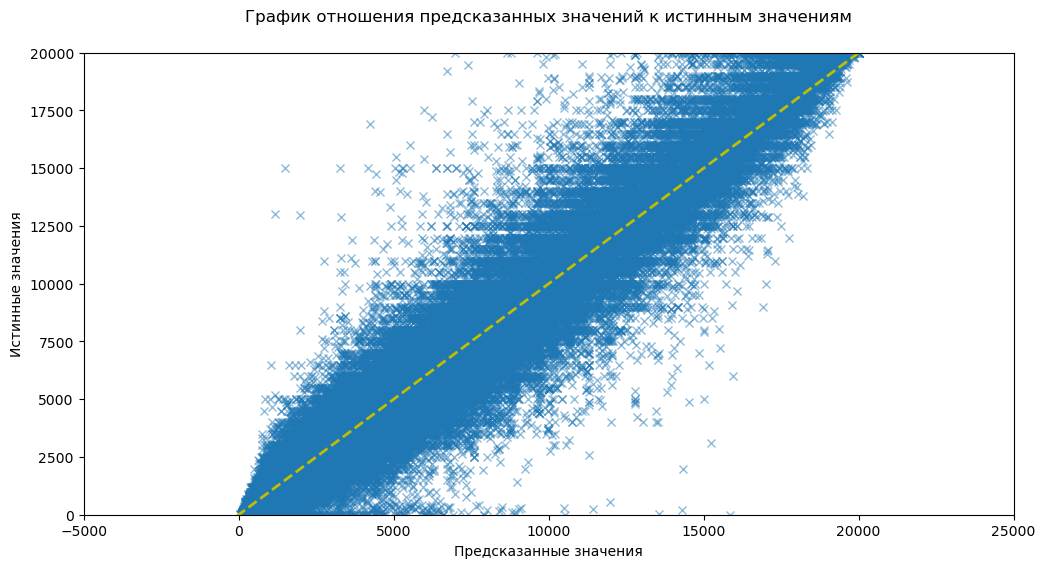

In [123]:
illustration_target(target_train_gbm, predict_rf)

Факторы важности модели RandomForestRegressor:

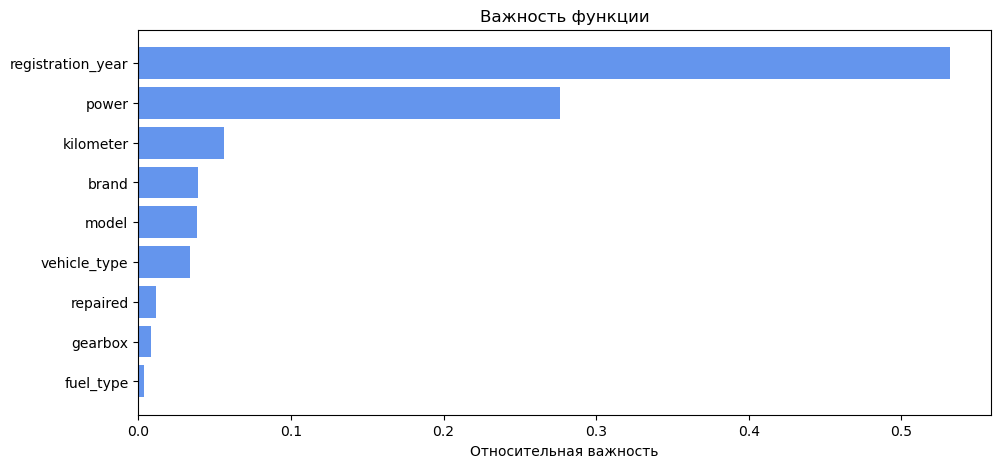

,Относительная важность
registration_year,0.531899
power,0.276361
kilometer,0.056311
brand,0.039263
model,0.038378
vehicle_type,0.034238
repaired,0.011579
gearbox,0.008226
fuel_type,0.003745


In [124]:
importances(model_rf, features_train_gbm)

#### CatBoostRegressor

In [125]:
model_cb = CatBoostRegressor(random_state=123, learning_rate=0.4, verbose=100, n_estimators=1000)

In [126]:
%%time
start = time.time()
scores_cb = cross_val_score(model_cb, features_train_gbm, target_train_gbm, cv=5, scoring='neg_root_mean_squared_error')
end = time.time()
v_cb=round(end-start,2)
print(scores_cb)

0:	learn: 3485.8446288	total: 173ms	remaining: 2m 53s
100:	learn: 1642.0315576	total: 2.65s	remaining: 23.6s
200:	learn: 1565.5799907	total: 5.12s	remaining: 20.4s
300:	learn: 1517.5760652	total: 7.55s	remaining: 17.5s
400:	learn: 1484.0269847	total: 10s	remaining: 15s
500:	learn: 1457.8899936	total: 12.6s	remaining: 12.5s
600:	learn: 1435.6089959	total: 15.3s	remaining: 10.1s
700:	learn: 1417.0788237	total: 17.7s	remaining: 7.55s
800:	learn: 1401.0759185	total: 20.2s	remaining: 5.02s
900:	learn: 1387.0440453	total: 23.1s	remaining: 2.54s
999:	learn: 1374.1227100	total: 25.6s	remaining: 0us
0:	learn: 3485.1511624	total: 27.4ms	remaining: 27.4s
100:	learn: 1647.9055608	total: 2.48s	remaining: 22.1s
200:	learn: 1569.4116008	total: 4.96s	remaining: 19.7s
300:	learn: 1519.3270803	total: 7.65s	remaining: 17.8s
400:	learn: 1487.7285571	total: 10.1s	remaining: 15s
500:	learn: 1460.8520877	total: 12.4s	remaining: 12.4s
600:	learn: 1438.8549500	total: 14.8s	remaining: 9.84s
700:	learn: 1418.979

Средняя метрика RMSE:

In [127]:
print('Средняя оценка:', pd.Series(scores_cb).mean())

Средняя оценка: -1576.7494838740859


In [128]:
rmse_cb = abs(pd.Series(scores_cb).mean())

In [129]:
rmse_cb 

1576.7494838740859

Обучим модель на тренировочных данных:

In [130]:
%%time
start = time.time()
model_cb.fit(features_train_gbm, target_train_gbm)
end = time.time()
f_cb=round(end-start,2)

0:	learn: 3497.4001934	total: 59.8ms	remaining: 59.7s
100:	learn: 1656.9622977	total: 3.14s	remaining: 27.9s
200:	learn: 1578.8935918	total: 6.16s	remaining: 24.5s
300:	learn: 1534.3645327	total: 9.21s	remaining: 21.4s
400:	learn: 1501.2466287	total: 12.2s	remaining: 18.3s
500:	learn: 1476.0602727	total: 15.3s	remaining: 15.2s
600:	learn: 1454.4521502	total: 18.4s	remaining: 12.2s
700:	learn: 1436.8528821	total: 21.4s	remaining: 9.11s
800:	learn: 1421.9393628	total: 24.3s	remaining: 6.04s
900:	learn: 1407.4532447	total: 27.3s	remaining: 3s
999:	learn: 1395.4506355	total: 30.3s	remaining: 0us
Wall time: 30.7 s


Произведём расчёт времени предсказания:

In [131]:
%%time
start = time.time()
predict_cb = model_cb.predict(features_train_gbm)
end = time.time()
p_cb=round(end-start,2)

Wall time: 81.5 ms


Показатели предсказания модели CatBoostRegressor:

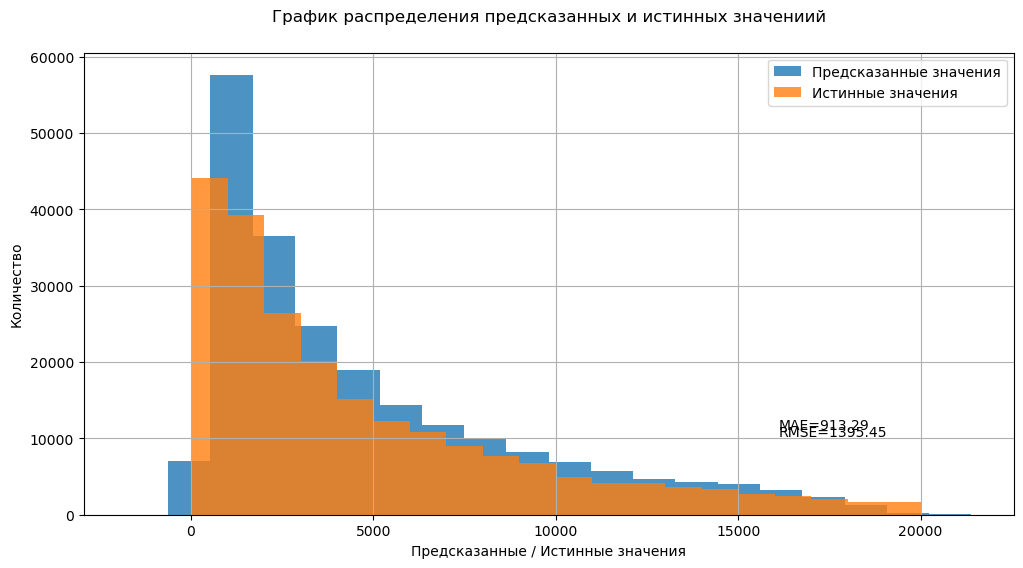

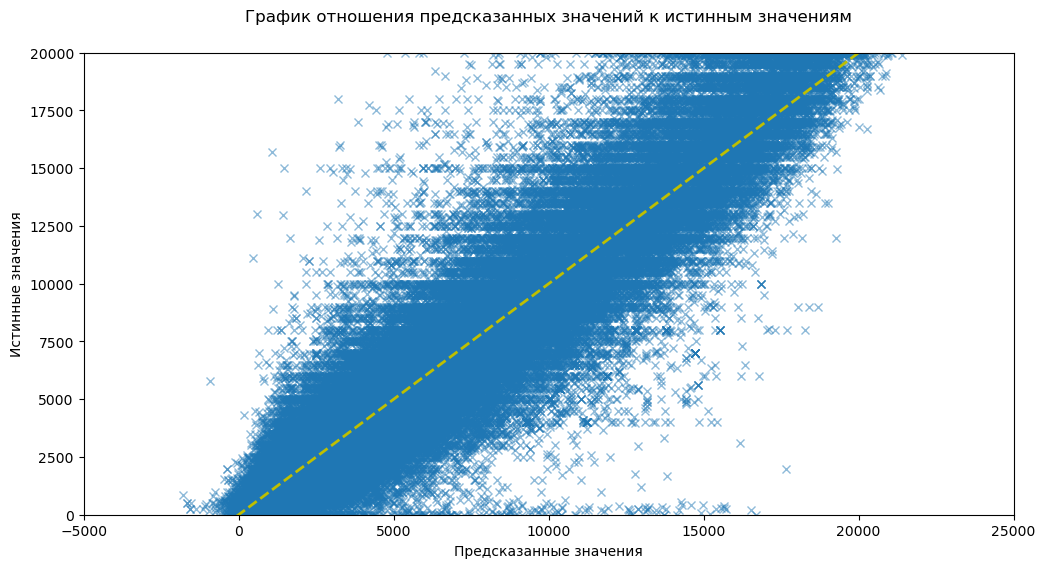

In [132]:
illustration_target(target_train_gbm, predict_cb)

Факторы важности модели CatBoostRegressor:

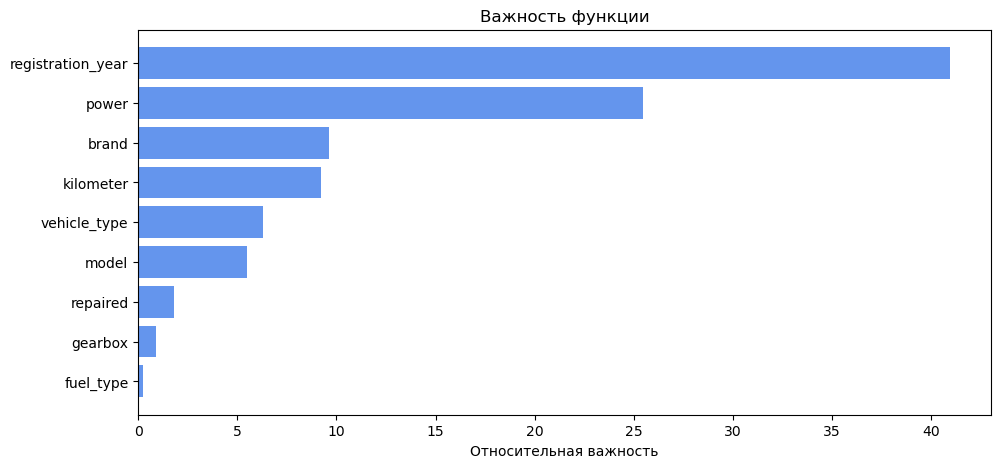

,Относительная важность
registration_year,40.959063
power,25.464768
brand,9.610942
kilometer,9.233541
vehicle_type,6.274909
model,5.509283
repaired,1.823125
gearbox,0.884734
fuel_type,0.239635


In [133]:
importances(model_cb, features_train_gbm)

#### LightGBM

In [134]:
model_lgbm = LGBMRegressor(learning_rate=0.4, n_estimators=1000, random_state=12345)

In [135]:
%%time
start = time.time()
scores_lgbm = cross_val_score(model_lgbm, features_train_gbm, target_train_gbm, cv=5, scoring='neg_root_mean_squared_error')
end = time.time()
v_lgbm=round(end-start,2)
print(scores_lgbm)

[-1571.59426276 -1577.56477161 -1568.48952202 -1583.13812419
 -1547.74459201]
Wall time: 32.4 s


Средняя метрика RMSE:

In [136]:
print('Средняя оценка:', pd.Series(scores_lgbm).mean())

Средняя оценка: -1569.706254517526


In [137]:
rmse_lgbm = abs(pd.Series(scores_lgbm).mean())

In [138]:
rmse_lgbm

1569.706254517526

Обучим модель на тренировочных данных:

In [139]:
%%time
start = time.time()
model_lgbm.fit(features_train_gbm, target_train_gbm)
end = time.time()
f_lgbm=round(end-start,2)

Wall time: 7.9 s


Произведём расчёт времени предсказания:

In [140]:
%%time
start = time.time()
predict_lgbm = model_lgbm.predict(features_train_gbm)
end = time.time()
p_lgbm=round(end-start,2)

Wall time: 1.34 s


Показатели предсказания модели LightGBM:

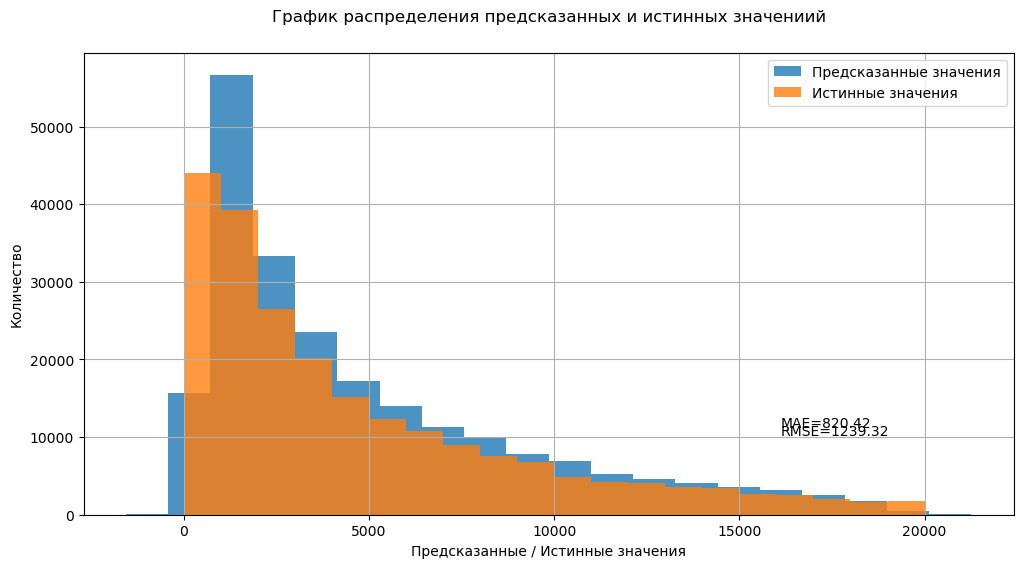

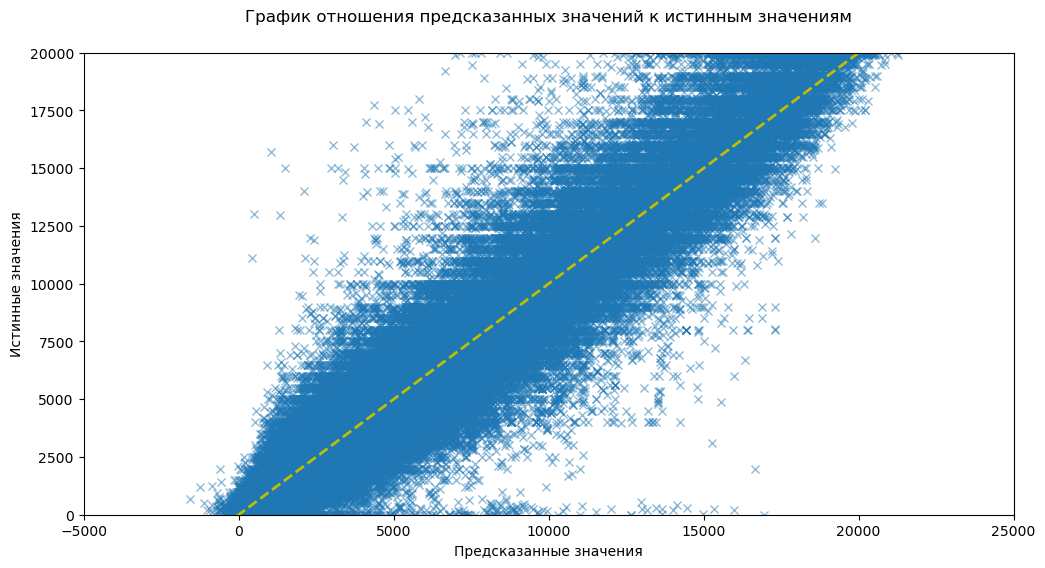

In [141]:
illustration_target(target_train_gbm, predict_lgbm)

Факторы важности модели LightGBM:

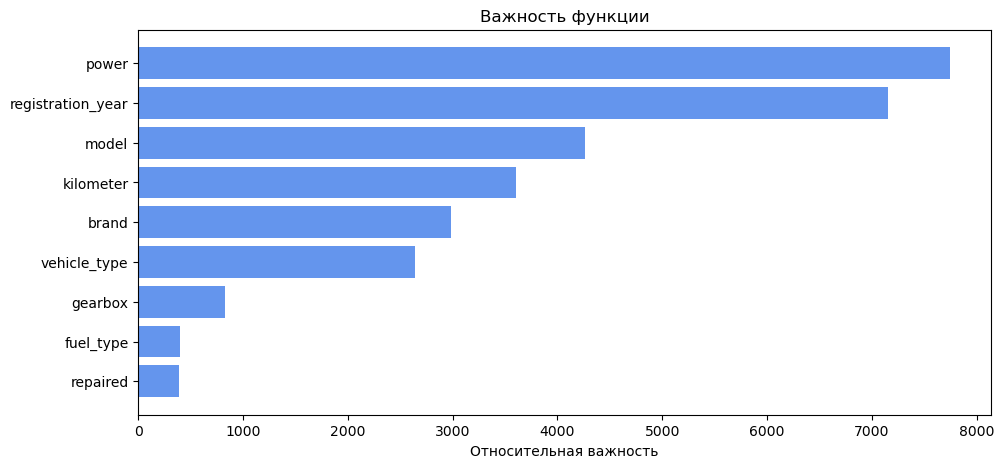

,Относительная важность
power,7746
registration_year,7151
model,4258
kilometer,3606
brand,2980
vehicle_type,2641
gearbox,829
fuel_type,400
repaired,389


In [142]:
importances(model_lgbm, features_train_gbm)

#### Выводы

Исходя из полученных данных:
- LinearRegression: из-за высокого показателя метрики RMSE в качестве модели обучения не подходит. также, из-за простоты модели, не позволяет оценить факторы важности с помощью "feature_importances";
- RandomForestRegressor: приемлиемые показатели метрики RMSE, при гиперпараметрах по-умолчанию. Среди факторов важности модель показала на первом месте год регистрации автомобиля, на втором мощность двигателя;
- CatBoostRegressor: показатели метрики RMSE уступили только модели LightGBM, при параметрах: random_state=123, learning_rate=0.4, verbose=100, n_estimators=1000 и количестве итераций - 997. Среди факторов важности модель показала на первом месте год регистрации автомобиля, на втором мощность двигателя;
- LightGBMRegressor: наилучшие показатели метрики RMSE при параметрах: n_estimators=1000, random_state=123, learning_rate=0.4, objective='rmse'. Среди факторов важности модель показала на первом месте мощность двигателя автомобиля, на втором  - год регистрации. 

## Анализ моделей

Обобщим данные по моделям:

In [143]:
column=['RMSE модели','Скорость кросс-валидации, s','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=['RMSE модели','Скорость кросс-валидации, s','Скорость обучения, s','Скорость предсказания, s'], 
                               columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = rmse_lr, v_lr, f_lr, p_lr
comparison_tabl['RandomForestRegressor'] = rmse_rf, v_rf, f_rf, p_rf
comparison_tabl['CatBoostRegressor'] = rmse_cb, v_cb, f_cb, p_cb
comparison_tabl['LightGBM'] = rmse_lgbm, v_lgbm, f_lgbm, p_lgbm

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column)

,RMSE модели,"Скорость кросс-валидации, s","Скорость обучения, s","Скорость предсказания, s"
LinearRegression,2641.655910,38.800000,9.130000,0.340000
RandomForestRegressor,1612.619760,351.540000,88.290000,18.460000
CatBoostRegressor,1576.749484,127.210000,30.670000,0.080000
LightGBM,1569.706255,32.410000,7.900000,1.340000


Определим лучшую модели для проверки на тестовой выборке: модель LightGBMRegressor, с минимальным значением метрики RMSE.

Проверим модель LightGBM на тестовой выборке:

In [144]:
%%time
start = time.time()
test_predict_lgbm = model_lgbm.predict(features_test_gbm)
end = time.time()
t_p_lgbm=round(end-start,2)

Wall time: 381 ms


In [145]:
rmse_lgbm = (mean_squared_error(test_predict_lgbm, target_test_gbm))**0.5
rmse_lgbm

1555.1175452206487

#### Вывод

По качеству предсказания на метрике лучше всех себя показала модель LightGBM, являющейся лидером по скорости кросс-валидации и обучения.Худшей моделью оказалась LinearRegression, с наихудшим значением метрики RMSE, и с самой низкой скоростю кросс-валидации и предсказания, что обусловлено кодированием категориальных признаков энкодером OneHotEncoder.

## Общие выводы

- Загружен датасет, получена общая информация;
- Выполнено удаление не акутальных для обучения моделей данных, названия данных приведены к строчным значениям;
- Обнаружены пропуски, объяснена возможная причина их появления;
- Найдены аномальные объекты, откорректированны;
- Данные подготовленны для обучения моделей.

Исходя из полученных данных:
- LinearRegression: из-за высокого показателя метрики RMSE в качестве модели обучения не подходит. также, из-за простоты модели, не позволяет оценить факторы важности с помощью "feature_importances";
- RandomForestRegressor: приемлиемые показатели метрики RMSE, при гиперпараметрах по-умолчанию. Среди факторов важности модель показала на первом месте год регистрации автомобиля, на втором мощность двигателя;
- CatBoostRegressor: показатели метрики RMSE уступили только модели LightGBM, при параметрах: random_state=123, learning_rate=0.4, verbose=100, n_estimators=1000 и количестве итераций - 997. Среди факторов важности модель показала на первом месте год регистрации автомобиля, на втором мощность двигателя;
- LightGBM: наилучшие показатели метрики RMSE при параметрах: n_estimators=1000, random_state=123, learning_rate=0.4, objective='rmse'. Среди факторов важности модель показала на первом месте мощность двигателя автомобиля, на втором  - год регистрации. 
- По качеству предсказания на метрике лучше всех себя показала модель LightGBM, являющейся лидером по скорости кросс-валидации и обучения. 
- Худшей моделью оказалась LinearRegression, с наихудшим значением метрики RMSE, и с самой низкой скоростю кросс-валидации и предсказания, что обусловлено кодированием категориальных признаков энкодером OneHotEncoder.

<b> Бонус

Произведём оценку поддержанного Renault Duster, 1986 года выпуска, c бензиновым двигателем, механической коробкой передач, мощностью двигателя в 115 л.с., с пробегом в 100000 км., который не был в ремонте. Данные будем использовать из файла 'new_data' - копии файла 'autos.scv', в котором оставлена только одна строка с вышеуказанным автомобилем. 

In [146]:
new_data = pd.read_csv(r'C:\Users\a1\Desktop\new_data.csv')

In [147]:
new_data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,NaN,NaN,suv,1986,manual,115,duster,100000,0,petrol,renault,no,NaN,0,NaN,NaN


Произведём предобработку данных, точно так же как и основного датасета:

In [148]:
new_data = new_data.drop(columns=['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'RegistrationMonth'], axis=1)

In [149]:
new_data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,NaN,suv,1986,manual,115,duster,100000,petrol,renault,no


In [150]:
new_data.columns = new_data.columns.str.lower()

In [151]:
new_data = new_data.rename(columns={'vehicletype':'vehicle_type',
                            'registrationyear':'registration_year',
                            'fueltype': 'fuel_type',
                            'notrepaired':'not_repaired'}
                  )

In [152]:
new_data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,NaN,suv,1986,manual,115,duster,100000,petrol,renault,no


In [153]:
features_n = new_data.drop(['price'], axis=1)
target_n = new_data['price']

Определим признаки обучающей выборки для модели LightGBM:

In [154]:
features_train_gbm_n = features_train.copy()
target_train_gbm_n = target_train.copy()
features_gbm_n = features.copy()

In [155]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [156]:
columns=['vehicle_type','model','fuel_type','brand','gearbox','repaired']
features_encoder = pd.DataFrame(encoder.fit_transform(features_gbm_n[columns]),
                            columns=features_gbm_n[columns].columns,
                           index=features_gbm_n[columns].index)
for column in columns:
    features_gbm_n[column] = features_encoder[column]
features_gbm_n

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,2.0,2011,1.0,190,166.0,125000,5.0,1.0,1.0
2,6.0,2004,0.0,163,117.0,125000,5.0,14.0,0.0
3,5.0,2001,1.0,75,116.0,150000,5.0,38.0,0.0
4,5.0,2008,1.0,69,101.0,90000,5.0,31.0,0.0
5,4.0,1995,1.0,102,11.0,150000,5.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
354361,3.0,2016,0.0,150,4.0,150000,4.0,0.0,0.0
354362,4.0,2004,1.0,225,140.0,150000,5.0,30.0,1.0
354366,1.0,2000,0.0,101,106.0,125000,5.0,32.0,0.0
354367,0.0,1996,1.0,102,223.0,150000,5.0,38.0,0.0


Добавляем закодированные признаки:

In [157]:
category_features_gbm = ['vehicle_type','model','fuel_type','brand','gearbox','repaired']

In [158]:
features_train_gbm_n[category_features_gbm] = encoder.transform(
    features_train_gbm_n[category_features_gbm])
features_n[category_features_gbm] = encoder.transform(
    features_n[category_features_gbm])

In [159]:
features_n

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,6.0,1986,1.0,115,94.0,100000,5.0,27.0,0.0


In [160]:
numeric_features_gbm = ['power', 'registration_year', 'kilometer']

In [161]:
scaler = StandardScaler()
scaler.fit(features_gbm[numeric_features_gbm])
features_train_gbm_n[numeric_features_gbm] = scaler.transform(
    features_train_gbm_n[numeric_features_gbm])
features_n[numeric_features_gbm] = scaler.transform(
    features_n[numeric_features_gbm])

Проверяем признаки подержанного Renault Duster после прямого кодирования и масштабирования:

In [162]:
features_n

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,6.0,-2.589639,1.0,-0.102739,94.0,-0.769639,5.0,27.0,0.0


Теперь применим модель LGBMRegressor для вычисления рыночной стоимости:

In [163]:
model_lgbm_n = LGBMRegressor(learning_rate=0.4, n_estimators=1000, random_state=12345)

In [164]:
grid = cross_val_score(model_lgbm_n, 
                       features_train_gbm, 
                       target_train_gbm,
                       cv=5, 
                       scoring='neg_root_mean_squared_error'
)

In [165]:
model_lgbm_n.fit(features_train_gbm_n, target_train_gbm_n)

LGBMRegressor(learning_rate=0.4, n_estimators=1000, random_state=12345)

Используем предсказание модели LightGBM, применяя вместо тестовых признаков, признаки нашего автомобиля:

In [166]:
%%time
start = time.time()
test_predict_lgbm_n = model_lgbm_n.predict(features_n)
end = time.time()
t_p_lgbm =round(end-start,2)

Wall time: 2 ms


In [168]:
print('Стоимость подержанного автомобиля:', int(test_predict_lgbm_n), 'евро.')              

Стоимость подержанного автомобиля: 3275 евро.
